In [1]:
import sys
import os
sys.path.insert(0, os.path.join('..','..','src'))
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
from analysis import data_exploration as dataexp
from utils import kaggle_reader as kr

In [3]:
homepath = os.path.join('..','..')
f = os.path.join(homepath,'data','raw','stage1_train_labels.csv')
decodedlabels = kr.read_kaggle_csv(f)
# load all the images into gray scale
impath = os.path.join(homepath, 'data', 'raw', 'stage1_train')
imgDF = kr.load_all_images(impath, mode='L')
# find nuclei bounding box information
boxDF = kr.find_mask_bounding_box(decodedlabels, imgDF)

Images in the raw data can be color or gray scale. It would be a good idea to convert all the images into gray scale so they are comparable. Below we compare the pixel values of the nuclei extractions to see if there is a consistent value. We also extract the 10% and 90% of the pixel values in each image to investigate if we need to rescale the images.

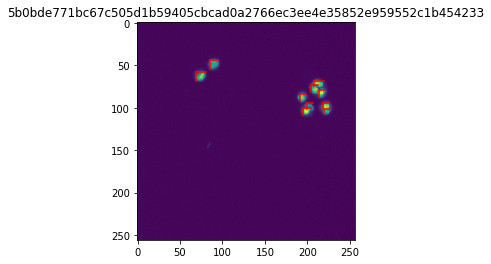

In [4]:
testimgId = np.random.choice(imgDF.ImageId)
kr.visual_check_boxes(boxDF, imgDF, testimgId)

In [5]:
def isolate_nuclei_background_in_grayscale(imgid, decodedlabels, imgDF):
    """
    collects the pixel values (in gray scale) of nucleis and background (non-nuclei regions) in a single gray scale
    image
    :param imgid: the ImageId to work on
    :param decodedlabels: decoded pixel labels read from Kaggle csv and decoded (see utils/kaggle_reader.py)
    :param imgDF: dataframe of all the images, loaded by load_all_images in utils/kaggle_reader.py
    :return: two 1D arrays: first an array of pixel values for the nucleis, second an array of pixel values for the
            background
    """

    # find all the nucleis associated with the given image
    nucleis = decodedlabels[decodedlabels.ImageId == imgid].DecodedPixels.values
    # find the image data and ravel it in 1D format along the row (FORTRAN style)
    imgvec = imgDF[imgDF.ImageId == imgid].ImageMat.values[0]
    imgvec = imgvec.ravel(order='F')
    # initialize the list for pixel indices that are part of a nuclei
    all_nuclei_index = []
    for nuclei in nucleis:
        # add pixel indices from each nuclei to the common list
        all_nuclei_index.extend(nuclei)
    # generate a mask the same size of the raveled image vector where True = background and False = nuclei
    mask = np.ones(imgvec.shape, dtype=bool)
    mask[all_nuclei_index] = False
    return imgvec[~mask], imgvec[mask]

In [6]:
nucleivals, backgroundvals = isolate_nuclei_background_in_grayscale(testimgId, decodedlabels, imgDF)

Text(0.5,0,'pixel value (gray-scale)')

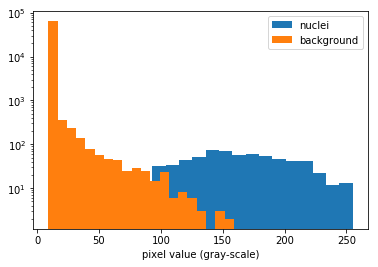

In [7]:
plt.hist(nucleivals, bins=20)
plt.hist(backgroundvals, bins=20)
plt.yscale('log', nonposy='clip')
plt.legend(['nuclei', 'background'])
plt.xlabel('pixel value (gray-scale)')

This single example above shows that the nuclei and background pixels are generally different in its pixel values (represented as brightness in a gray scale image). Below we extract the mean value of pixel values in both the nucleis and the background (not nuclei) for each image and compare the statistics.

In [8]:
def gather_pixel_means(decodedlabels, imgDF):
    """
    Gathers the mean pixel value (in gray scale) of the nucleis and background in each image
    :param decodedlabels: decoded pixel labels read from Kaggle csv and decoded (see utils/kaggle_reader.py)
    :param imgDF: dataframe of all the images, loaded by load_all_images in utils/kaggle_reader.py
    :return: a dataframe containing the ImageId, mean pixel vale of all the nucleis in this image, and mean pixel values
            of the background in this image
    """

    # initialize the lists for mean pixel values and ImageID
    background_mean = []
    nuclei_mean = []
    imageids = []
    # iterate through all images, using ImageID (imgid) to identify each image
    for imgid in imgDF.ImageId:
        # acquire pixel values for the nucleis and background
        nucleivals, backgroundvals = isolate_nuclei_background_in_grayscale(imgid, decodedlabels, imgDF)
        # calculate the mean values
        background_mean.append(backgroundvals.mean())
        nuclei_mean.append(nucleivals.mean())
        # record the ImageId
        imageids.append(imgid)
    return pd.DataFrame(list(zip(imageids, nuclei_mean, background_mean)),
                        columns=['ImageId', 'nucleiMean', 'backgroundMean'])

In [9]:
pixelvalDF = gather_pixel_means(decodedlabels, imgDF)

In [10]:
pixelvalDF = pixelvalDF.assign(SNratio = pixelvalDF.nucleiMean/pixelvalDF.backgroundMean)
pixelvalDF.describe()

,nucleiMean,backgroundMean,SNratio
count,670.000000,670.000000,670.000000
mean,65.882070,40.562601,6.633527
std,34.935641,67.554396,5.115514
min,17.267841,0.409122,0.420516
25%,36.118141,4.633588,3.651022
50%,57.306512,7.933784,5.911129
75%,94.295126,16.260983,9.640472
max,187.251309,219.092193,54.521035


In most images the nuclei has higher values than background. However, in some images this relationship is flipped. In some images the nuclei are expressed as bright spots while in others they are expressed as dark spots. We can invert the numbers less than 1 to get a better measure of the nuclei to background contrast.

In [11]:
newratio = 1.0 / pixelvalDF[pixelvalDF.SNratio < 1].SNratio.values
pixelvalDF.loc[pixelvalDF.SNratio < 1,'SNratio'] = newratio

In [12]:
pixelvalDF.describe()

,nucleiMean,backgroundMean,SNratio
count,670.000000,670.000000,670.000000
mean,65.882070,40.562601,6.859472
std,34.935641,67.554396,4.864279
min,17.267841,0.409122,1.197580
25%,36.118141,4.633588,3.651022
50%,57.306512,7.933784,5.911129
75%,94.295126,16.260983,9.640472
max,187.251309,219.092193,54.521035


Text(0.5,0,'log10(nuclei pixel value/background pixel value)')

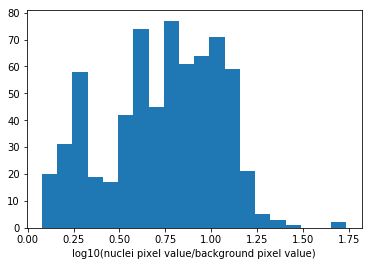

In [13]:
plt.hist(np.log10(pixelvalDF.SNratio), bins = 20)
plt.xlabel('log10(nuclei pixel value/background pixel value)')

The plot suggests a lot of images have very close values between nucleis and background. This may suggest that pixel values alone is not a good feature to use to separate the nucleis and the background. 

Next we investigate the variation in nuclei sizes. This will help us determine the window size for the sliding window method and the levels of scaling needed for the images.

In [14]:
intraImage_std = boxDF.groupby('ImageId').apply(np.std)

In [15]:
# descriptive stats on intra image stds
intraImage_std.describe()[['boxH', 'boxW']]

,boxH,boxW
count,670.000000,670.000000
mean,8.350856,8.513679
std,6.161170,6.349670
min,0.000000,0.000000
25%,3.633955,3.728856
50%,6.357922,6.486577
75%,11.175262,11.560886
max,32.097075,34.883935


In [16]:
# STD for all box height and width
np.std(boxDF[['boxH','boxW']])

boxH    13.619105
boxW    13.821911
dtype: float64

There is a lot of variation in box sizes. And the variation is not just between images but also within a single image. For example, the image below has a large variance in the nuclei heights. Part of the issue is due to partial nucleis close to the edge of an image.

In [17]:
# reload images in RGB mode for better display
# load all the images into gray scale
impath = os.path.join(homepath, 'data', 'raw', 'stage1_train')
imgDF = kr.load_all_images(impath, mode='RGB')

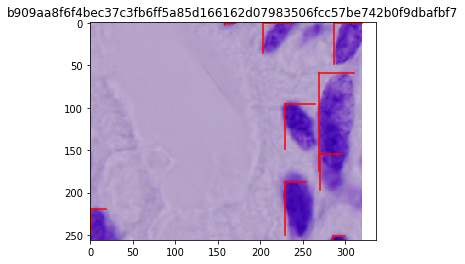

In [18]:
maxSTDHimg = intraImage_std.sort_values('boxH', ascending=False).iloc[0].name
kr.visual_check_boxes(boxDF, imgDF, maxSTDHimg)

The size differences will inflence how we choose to scale the image and what size to use for the initial sliding window. Idealy we want to use a window that can cover the small nucleis then scale the image down gradually so that the same box can cover increasingly larger nuclei sizes. The stats below reveal some very narrow or short nucleis, with just 1 pixel in size in the respective dimension. Fortunately not many nucleis have that kind of dimension, as shown in the histogram below (note, the horizontal axis is log10 of the dimensions to emphasize the small end of the sizes)

In [19]:
boxDF[['boxH', 'boxW']].describe()

,boxH,boxW
count,29461.000000,29461.000000
mean,22.550287,22.929059
std,13.619336,13.822146
min,1.000000,1.000000
25%,12.000000,13.000000
50%,20.000000,21.000000
75%,29.000000,29.000000
max,139.000000,122.000000


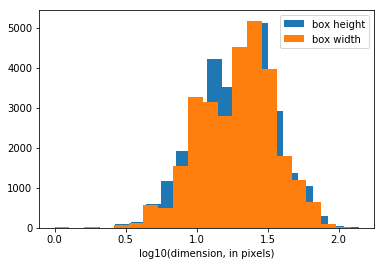

In [20]:
plt.hist(np.log10(boxDF.boxH), bins=20)
plt.hist(np.log10(boxDF.boxW), bins=20)
plt.xlabel('log10(dimension, in pixels)')
plt.legend(['box height', 'box width'])

Next, we explore the aspect ratio of the boxes to find the optimum aspect ratio for the sliding window.

In [21]:
boxDF = boxDF.assign(boxHoW = boxDF.boxH/boxDF.boxW)
boxDF.describe()

,boxminR,boxmaxR,boxminC,boxmaxC,boxH,boxW,imgW,imgH,boxHoW
count,29461.000000,29461.000000,29461.000000,29461.000000,29461.000000,29461.000000,29461.000000,29461.000000,29461.000000
mean,193.860426,215.410712,236.013102,257.942161,22.550287,22.929059,404.408642,506.068090,1.094878
std,158.017122,159.186734,202.869023,203.984905,13.619336,13.822146,187.400013,282.185678,0.951989
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,256.000000,256.000000,0.021277
25%,76.000000,98.000000,86.000000,107.000000,12.000000,13.000000,256.000000,256.000000,0.794521
50%,167.000000,188.000000,185.000000,205.000000,20.000000,21.000000,360.000000,360.000000,1.000000
75%,258.000000,287.000000,319.000000,348.000000,29.000000,29.000000,520.000000,696.000000,1.222222
max,1021.000000,1039.000000,1294.000000,1388.000000,139.000000,122.000000,1040.000000,1388.000000,57.000000


Text(0.5,0,'log(Height/weight)')

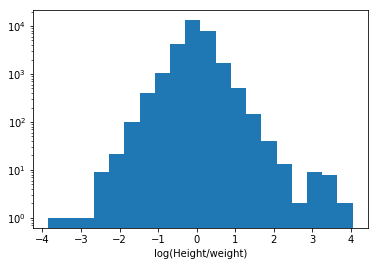

In [22]:
plt.hist(np.log(boxDF.boxHoW), bins=20)
plt.yscale('log', nonposy='clip')
plt.xlabel('log(Height/weight)')

The majority of the nucleis has an aspect ratio close to 1 (0 on the log(aspect ratio) plot. There are extremely slim (very large height/weight ratio) or short (very small height/weight ratio) nucleis. Some of them are just partial nucleis appearing at the edge of the images, like a few example below.

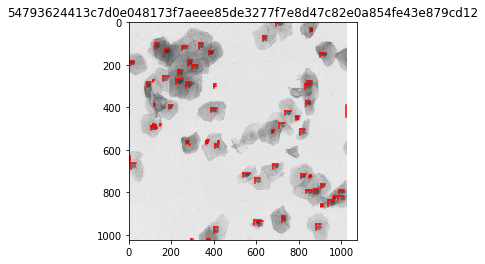

In [23]:
maxHoWimg = boxDF.sort_values('boxHoW', ascending=False).iloc[0].ImageId
kr.visual_check_boxes(boxDF, imgDF, maxHoWimg)

The table below shows that nucleis with extremely small height (1-3 pixel sizes) are usually very wide, suggesting the nucleis with one extreme dimension also has an aspect ratio very different from 1. Combining this observation and the observation that most nuclei bounding boxes has an aspect ratio of 1. We may start the sliding window with an aspect ratio of 1 and a size of 5 (the first size where aspect ratio of 1 appears). This way we can theoritically fit all the nucleis in a single box when image gradually shrinks.

In [24]:
boxDF[['boxH', 'boxW', 'boxHoW']].groupby('boxH').min()

,boxW,boxHoW
boxH,,
1,47,0.021277
2,11,0.042553
3,7,0.065217
4,6,0.108108
5,5,0.087719
6,4,0.139535
7,4,0.134615
8,3,0.086957
9,3,0.176471
